<a href="https://colab.research.google.com/github/rfraissinet/portfolio_projects/blob/main/Predicting_Airline_Tweet_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Airline Tweet Sentiment**

### **Context**:
Twitter created an environment where people can express succinct opinions at a moment's notice (for better or for worse!). Users submit thoughts on everything from Netflix shows to presidential elections to travel experiences. The last example is why we're here. Among the plethora of tweets in the "Twittersphere," there is bountiful information about airline customer experiences just waiting for someone to analyze it. But analyzing text data isn't so straightforward. To do so, we'll have to use some specific model-building techniques designed for this purpose.

### **Objective**:

- To build a model that accurately classifies the sentiment of airline tweets into the positive, neutral & negative.
 
### **Data Description**:
- This dataset is available on [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).
- From the original source:


> "*A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").*"

### **Table of Contents**
1. [Data Overview](#overview)
2. [EDA](#eda)
3. [Data Preprocessing](#preprocessing)
4. [Count Vectorizer and Random Forest Model](#cv)
5. [TF-IDF and Random Forest Model](#tf)
6. [Actionable Insights and Recommendations](#recs)

### Importing libraries

In [1]:
# for data manipulation and visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud.wordcloud import WordCloud, STOPWORDS

# for pre-processing text
!pip install contractions
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from bs4 import BeautifulSoup
import re
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# for model building
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.1/110.1 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 8.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
# removing column width limit
pd.set_option('display.max_colwidth', None)

### Reading the dataset <a name="overview"></a>


In [3]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read the data
data = pd.read_csv('/content/drive/MyDrive/Career/AI Course/Projects/Twitter US Airline Sentiment/Tweets.csv')

### Checking the shape of the dataset

In [5]:
print(f'There are {data.shape[0]} rows and {data.shape[1]} columns.')

There are 14640 rows and 15 columns.


### Displaying the first few rows of the dataset

In [6]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


- There is a mix of numeric and text data.
- Our model will focus on `airline_sentiment` and `text`, our dependent and independent variables.
- We can drop the `tweet_id` column, as it is irrelevant to us.

In [7]:
# dropping the tweet_id column
data = data.drop('tweet_id', axis=1)

### Checking for missing values

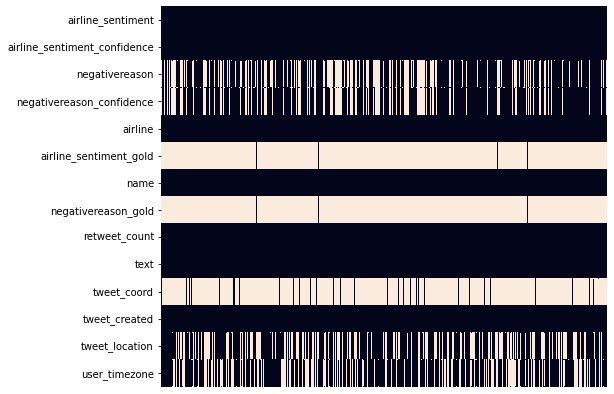

In [8]:
# creating a heatmap of all missing values
plt.figure(figsize=(8,7))
sns.heatmap(data.isnull().T, cbar=False, xticklabels=[])
plt.show()

- There are missing values in the `negativereason` and `negativereason_confidence` columns.
  - These missing values seem to correlate with one another. For one, there won't be values in either column when the `airline_sentiment` is positive. It is also possible that the `negativereason` field was left blank if the reason was unclear.
- There appear to be only a few values for `airline_sentiment_gold` and `negativereason_gold`.
- Most tweets don't have coordinate data.
- `tweet_location` and `user_timezone` values are sparse as well.

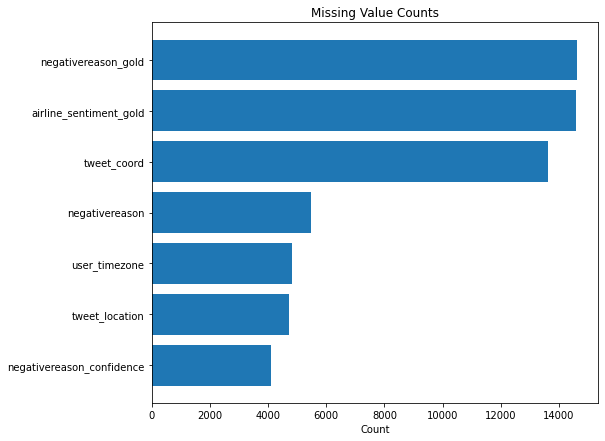

In [9]:
# creating a bar chart of missing value counts
plt.figure(figsize=(8,7))
null_counts = data.isnull().sum().sort_values(ascending=True)
null_counts = null_counts[-7:] # only selecting columns with null values                              
plt.barh(y=null_counts.index, width=null_counts.values)
plt.title('Missing Value Counts')
plt.xlabel('Count')
plt.show()

- As we saw above, most missing values occur in the `negativereason_gold` and `airline_sentiment_gold` columns.
- Luckily, these columns aren't relevant to model building, so we don't have to worry about treating them.

### EDA <a name="eda"></a>



I'll start by answering a few questions and then proceed with the rest of the EDA from there.

**What is the percentage of tweets for each airline?**

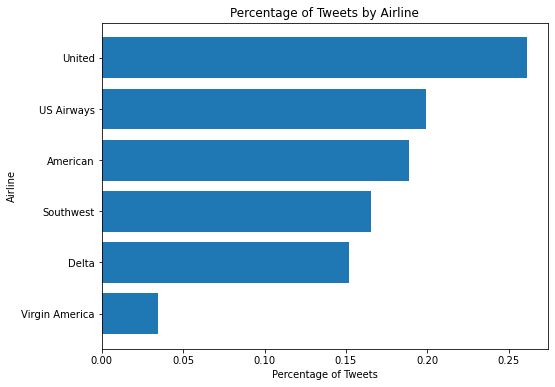

In [10]:
# getting airline value counts
perc_by_airline = data['airline'].value_counts(normalize=True)
# creating plot
plt.figure(figsize=(8,6))
plt.barh(perc_by_airline.sort_values().index, width=perc_by_airline.sort_values().values)
plt.xlabel('Percentage of Tweets')
plt.ylabel('Airline')
plt.title('Percentage of Tweets by Airline')
plt.show()

- The most discussed airline is United, with slightly more than 25 percent of the tweets.
- US Airways and American follow.
- Virgin America has the fewest amount of tweets at less than 4 percent.

**What is the distribution of sentiments across all the tweets?**


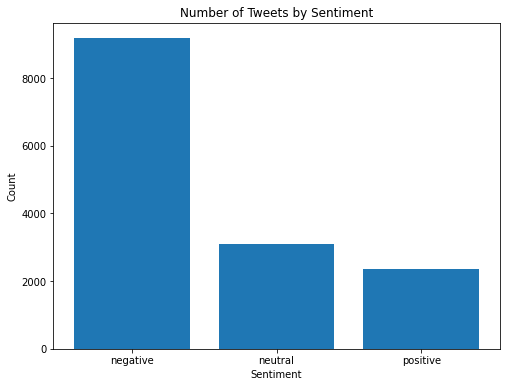

In [11]:
# getting sentiment value counts
sentiment_breakdown = data['airline_sentiment'].value_counts()
# creating plot
plt.figure(figsize=(8,6))
plt.bar(sentiment_breakdown.index, height=sentiment_breakdown.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Number of Tweets by Sentiment')
plt.show()

- The majority of tweets are negative. This may be due to the fact that people tend to post about negative experiences, not positive ones.
- This imbalance is something to consider when we build our models. We will need to stratify our train/test splits and consider upsampling or downsampling the data.

**What is the distribution of sentiments for each airline?**

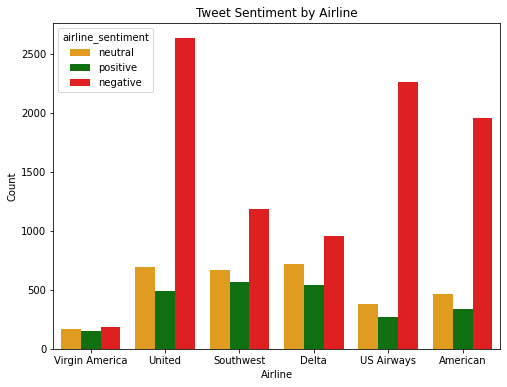

In [12]:
# creating a plot of sentiment breakdown by airline
plt.figure(figsize=(8,6))
sns.countplot(x=data['airline'], hue=data['airline_sentiment'], palette=["Orange", "Green", "Red"])
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Tweet Sentiment by Airline')
plt.show()

- United has the highest number of negative tweets.
- US Airways and American are second and third.
- For every airline, negative tweets make up the highest fraction of tweets and positive tweets make up the smallest fraction.
- Southwest has more positive tweets than United, but less than half as many negative tweets as United.
- US Airways has half as many positive tweets as Southwest but almost twice as many negative tweets.
- Delta and Southwest appear to garner the fewest negative tweets, whereas United, US Airways, and American have much higher rates of negative tweets.

**What does the plot of negative reasons indicate?**

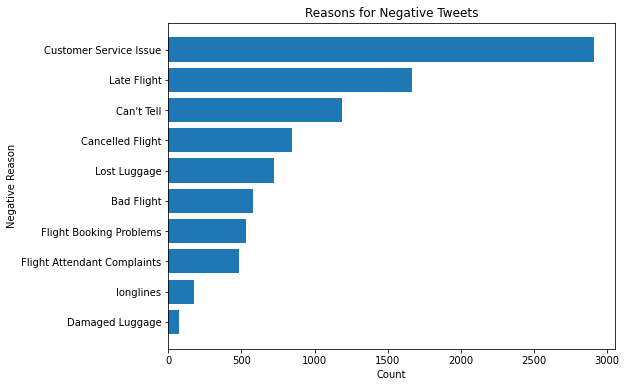

In [13]:
# filtering for all negative tweets and extracting the reason
reasons_for_negative = data[data['airline_sentiment'] == 'negative']['negativereason'].value_counts().sort_values(ascending=True)
# creating plot of negative reason counts
plt.figure(figsize=(8,6))
plt.barh(reasons_for_negative.index, reasons_for_negative.values)
plt.xlabel('Count')
plt.ylabel('Negative Reason')
plt.title('Reasons for Negative Tweets')
plt.show()

- Nearly 3000 negative tweets specify a customer service issue - the highest of any category.
- The next most common reason for a negative tweet is a late flight.
- Very few users took issue with long lines or complained about damaged luggage.

**What are the most common words across negative tweets?**

In [14]:
# extracting all negative tweets
negative_tweets = data[data['airline_sentiment'] == 'negative']

# joining all tweets into a single string
negative_tweets_joined = (' ').join(negative_tweets['text'])

# discarding all mentions, retweets, and hyperlinks and rejoining tweets
negative_words_cleaned = []
for word in negative_tweets_joined.split():
  if word.startswith('@') == False and word != 'RT' and 'http' not in word:
    negative_words_cleaned.append(word)
negative_words_cleaned = " ".join(word for word in negative_words_cleaned)

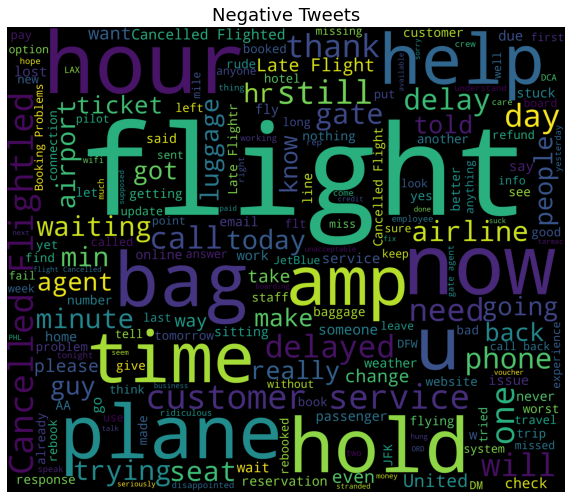

In [15]:
# creating a function to plot wordclouds
def create_wordcloud(string, title):
  """
  Function to plot a wordcloud.
  
  string: a string of all words separated by spaces
  title: a string to title the plot
  """
  wordcloud = WordCloud(stopwords=STOPWORDS, width=3000, height=2500).generate(string)
  plt.figure(figsize=(10,10))
  plt.title(title, {'fontsize': 18})
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

# creating wordcloud of negative tweets
create_wordcloud(negative_words_cleaned, 'Negative Tweets')

- The most common word in all negative tweets was 'flight'.
- Other common words like 'time', 'hour', 'now', and 'hold' likely describe delays.
- 'Bag' is also common, and probably goes along with luggage issues.
- The significance of 'help' makes sense, as customers having negative experiences might contact the airline via Twitter for assistance.

**What are the most common words across positive tweets?**

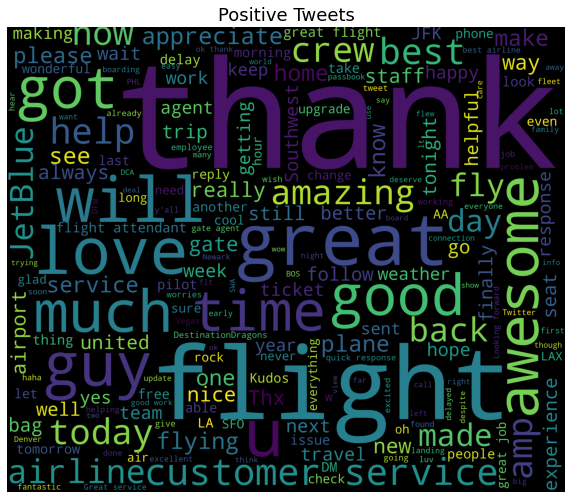

In [16]:
# extracting all positive tweets
positive_tweets = data[data['airline_sentiment'] == 'positive']

# joining tweets into a single string
positive_tweets_joined = (' ').join(positive_tweets['text'])

# discarding all mentions, retweets, and hyperlinks and rejoining tweets
positive_words_cleaned = []
for word in positive_tweets_joined.split():
  if word.startswith('@') == False and word != 'RT' and 'http' not in word:
    positive_words_cleaned.append(word)
positive_words_cleaned = " ".join(word for word in positive_words_cleaned)

# plotting wordcloud
create_wordcloud(positive_words_cleaned, 'Positive Tweets')

- 'Thank' is the most common word for positive tweets. Any tweet where a user is thanking an airline is probably positive.
- Words like 'awesome', 'great', 'love', and 'good' also convey positivity.
- 'Customer service' is prominent, likely because customers tweet about positive experiences they have with customer service.
- 'Will' is also fairly large in the plot, perhaps because happy customers tweet that they 'will' fly with the airline again in the future.

### EDA cont'd

#### Airline Sentiment Confidence

<Figure size 576x432 with 0 Axes>

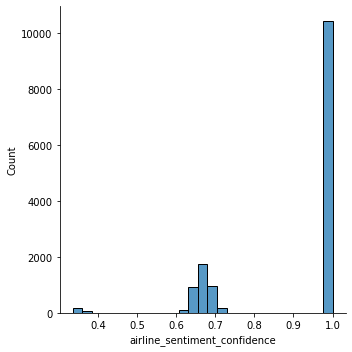

In [17]:
# creating a distribution plot for airline sentiment confidence
plt.figure(figsize=(8,6))
sns.displot(data=data, x='airline_sentiment_confidence')
plt.show()

- The vast majority of tweets have an `airline_sentiment_confidence` of 1.0, indicating high confidence that the sentiment value is accurate.
- There is a normal distribution of sentiments around 0.66. This signals the presence of tweets whose sentiment values are less robust.
- A few tweets' sentiment confidence falls at the low end of the range near 0.3.


#### Negative Reason Confidence

<Figure size 576x432 with 0 Axes>

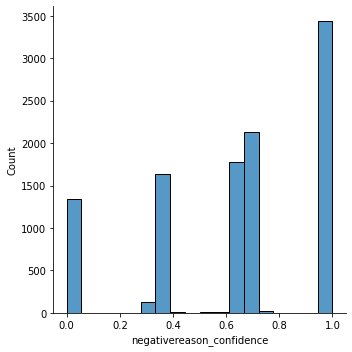

In [18]:
# creating a distribution plot for negative reason confidence
plt.figure(figsize=(8,6))
sns.displot(data=data, x='negativereason_confidence')
plt.show()

- This plot depicts a few common values with spaces in between.
- The most common negative reason confidence level is 1.0, indicating strong confidence in the accuracy of the negative reason value.
- There are spikes near 0.0, 0.4, and 0.6, which reflect lower levels of confidence.

#### Airline Sentiment Gold

<Figure size 576x432 with 0 Axes>

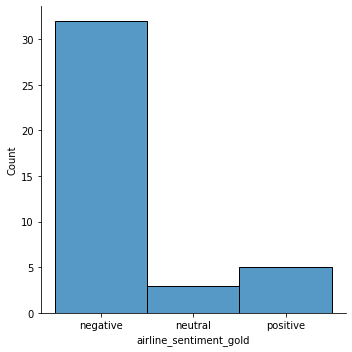

In [19]:
# creating a distribution plot for airline sentiment gold
plt.figure(figsize=(8,6))
sns.displot(data=data, x='airline_sentiment_gold')
plt.show()

- This plot is similar to the `airline_sentiment` plot in terms of proportions, but there are far fewer values.
- The vast majority of gold sentiments are negative.
- I tried to find information on this column on Kaggle, but was unable to locate a description.

#### Negative Reason Gold

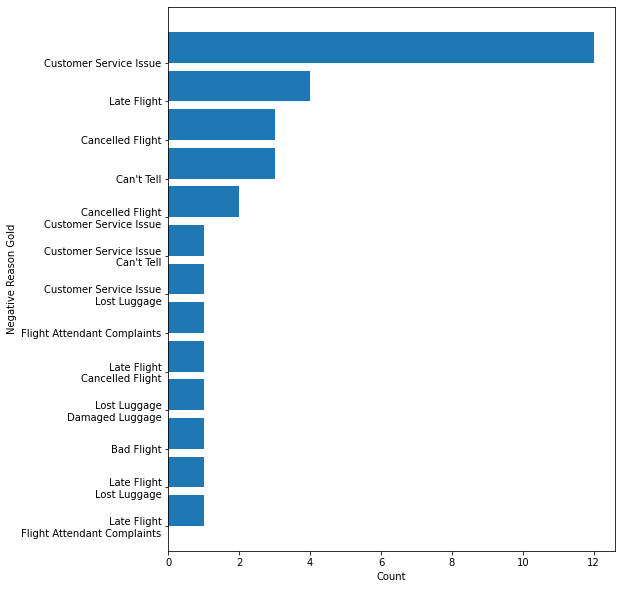

In [20]:
# creating a distribution plot for negative reason gold
neg_reason_gold_vc = data['negativereason_gold'].value_counts(ascending=True)
plt.figure(figsize=(8,10))
plt.barh(neg_reason_gold_vc.index, neg_reason_gold_vc.values, align='edge', height=.8)
plt.xlabel('Count')
plt.ylabel('Negative Reason Gold')
plt.show()

- Similar to the previous column, this plot mirrors the `negativereason` plot, but with fewer values.
- The most common negative reason is a customer service issue.

#### Retweet Count

In [21]:
# finding tweets with the highest number of retweets
data[['airline_sentiment', 'name', 'retweet_count', 'text']].sort_values('retweet_count', ascending=False)[:11]

,airline_sentiment,name,retweet_count,text
11596,negative,OBJ_3,44,"@USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home 👠👠👠 (3 heel clicks)"
11582,negative,OBJ_3,32,@USAirways of course never again tho . Thanks for tweetin ur concern but not Doin anythin to fix what happened. I'll choose wiser next time
7132,negative,TatianaKing,31,STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY. RT @JetBlue: Our fleet's on fleek. http://t.co/Fd2TNYcTrB
9999,neutral,airliners2,28,@USAirways with this livery back in the day. http://t.co/EEqWVAMmiy
5607,positive,seattlefordguy,22,@SouthwestAir beautiful day in Seattle! http://t.co/iqu0PPVq2S
7115,negative,TheBuie,22,can you not? RT @JetBlue Our fleet's on fleek. http://t.co/413GiAL0yl
7027,negative,AbeFroman,18,"Just in case you needed confirmation that ""on fleek"" is dead &amp; gone. RT @JetBlue: Our fleet's on fleek. http://t.co/G4O6yX7TMJ"
7111,neutral,No_Cut_Card,15,X____x RT @JetBlue: Our fleet's on fleek. http://t.co/Y39YzDpBvU
7453,positive,OlivierGachot,11,"@JetBlue what a great experience on flight from SFO to JFK; seats, service, food, everything is top quality. I will be back. Very soon!"
9453,positive,Blasterjaxx,9,@USAirways Wow unbelievable how you treat your customers at Puerto Rico airport! 👍


In [22]:
# viewing retweet value counts
data['retweet_count'].value_counts().sort_index(ascending=False)

44        1
32        1
31        1
28        1
22        2
18        1
15        1
11        1
9         1
8         1
7         3
6         3
5         5
4        17
3        22
2        66
1       640
0     13873
Name: retweet_count, dtype: int64

- Only a handful of tweets have more than 4 retweets.

In [23]:
# finding users with the most retweets
data.groupby('name')['retweet_count'].sum().sort_values(ascending=False)[:10]

name
OBJ_3             80
JasonShaw2        31
TatianaKing       31
airliners2        28
seattlefordguy    22
TheBuie           22
NickTypesWords    20
AbeFroman         18
No_Cut_Card       15
davidgoodson71    13
Name: retweet_count, dtype: int64

- Twitter user 'OBJ_3' is Odell Beckham Jr., a wide receiver in the NFL. He currently has 4.4 million followers. Let's view his tweets.

In [24]:
# viewing tweets from OBJ_3
data[data['name'] == 'OBJ_3'][['name','text','retweet_count','tweet_created']]

,name,text,retweet_count,tweet_created
11582,OBJ_3,@USAirways of course never again tho . Thanks for tweetin ur concern but not Doin anythin to fix what happened. I'll choose wiser next time,32,2015-02-17 20:50:56 -0800
11591,OBJ_3,"@USAirways No need for apologies just an unfortunate situation . There is no up date, I've landed but was suppose to land at 5",4,2015-02-17 20:35:21 -0800
11596,OBJ_3,"@USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home 👠👠👠 (3 heel clicks)",44,2015-02-17 20:06:21 -0800


- It appears OBJ was upset with US Airways because his flight was delayed. His large following explains the high retweet count.
- Let's view the next user's tweets.

In [25]:
# viewing tweets from JasonShaw2
data[data['name'] == 'JasonShaw2'][['name','text','retweet_count','tweet_created']]

,name,text,retweet_count,tweet_created
12638,JasonShaw2,@AmericanAir yeah and what are they gunna? Nothing your whole organization is a joke,0,2015-02-23 20:38:53 -0800
12675,JasonShaw2,@AmericanAir this is the biggest joke I've ever seen and will be telling everyone never to use you guys cause you are a joke,4,2015-02-23 19:39:51 -0800
12676,JasonShaw2,@AmericanAir Pay for my accommodations when you are the ones Cancelled Flightling it for no reason and I know your saying (lying) it cause of weather,4,2015-02-23 19:38:58 -0800
12677,JasonShaw2,@AmericanAir airport and 2 extra nights for hotels and not once have I heard of anything from your embarrassing airline saying that you will,4,2015-02-23 19:37:24 -0800
12678,JasonShaw2,@AmericanAir This is getting a bit ridiculous when and you have made me miss 2 full days off work and had to pay for cabs back and forth,4,2015-02-23 19:35:55 -0800
12680,JasonShaw2,@AmericanAir Cancelled Flight my flight saying it is cause of weather condition when it was the only flight that was Cancelled Flight,5,2015-02-23 19:34:51 -0800
12681,JasonShaw2,@AmericanAir Again you guys are a huge joke and Cancelled Flight your flight for no reason. This is the 3rd time in one trip for me that you have,4,2015-02-23 19:33:49 -0800
14326,JasonShaw2,@AmericanAir why would I bother wasting my time calling them when they are gunna do nothing,2,2015-02-22 15:01:57 -0800
14333,JasonShaw2,@AmericanAir that's if it is ever complete and if i can ever get through customer service #theydontanswer,2,2015-02-22 14:56:30 -0800
14532,JasonShaw2,@AmericanAir missing a full days of work thanks guys,2,2015-02-22 13:02:29 -0800


- This user tweeted many times across two days. They claim their flight was cancelled three times and American didn't pay for their accommodations.
- They appear very angry.

In [26]:
# Viewing tweets from TatianaKing
data[data['name'] == 'TatianaKing'][['name','text','retweet_count','tweet_created']]

,name,text,retweet_count,tweet_created
7132,TatianaKing,STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY. RT @JetBlue: Our fleet's on fleek. http://t.co/Fd2TNYcTrB,31,2015-02-23 10:30:29 -0800


- This user appears to take issue with Jet Blue using the slang term 'fleek' to describe their airplanes.

#### Tweet Coordinates

In [27]:
# viewing the most common coordinate values
data['tweet_coord'].value_counts()[:5]

[0.0, 0.0]                     164
[40.64656067, -73.78334045]      6
[32.91792297, -97.00367737]      3
[40.64646912, -73.79133606]      3
[35.22643463, -80.93879965]      2
Name: tweet_coord, dtype: int64

- The most common coordinate values are 0.0, 0.0, which are not accurate (unless the user tweeted from [Null Island](https://en.wikipedia.org/wiki/Null_Island#:~:text=Null%20Island%20is%20the%20point,in%20the%20Gulf%20of%20Guinea.) in the middle of the Atlantic Ocean).
- The next most frequent coordinates are strikingly close to the fourth most common. After further investigation, `40.64656067, -73.78334045` and `40.64646912, -73.79133606` are the coordinates for [JFK Airport](https://en.wikipedia.org/wiki/John_F._Kennedy_International_Airport) in New York City.

#### Tweet Created

In [28]:
# converting the tweet_created column to datetime
data['tweet_created'] = pd.to_datetime(data['tweet_created'])

In [29]:
# separating the time column into hour, day, month, and year columns
data['time_hour'] = data['tweet_created'].dt.hour 
data['time_day'] = data['tweet_created'].dt.day
data['time_month'] = data['tweet_created'].dt.month
data['time_year'] = data['tweet_created'].dt.year

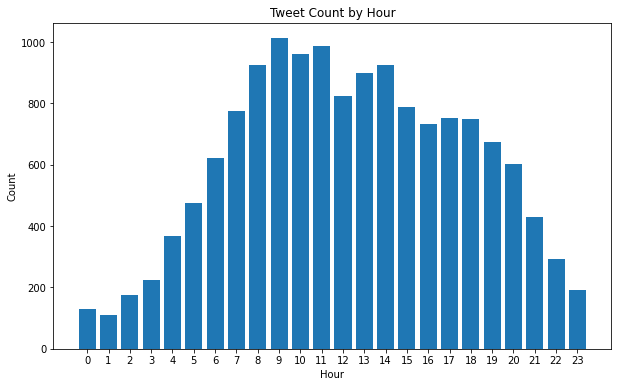

In [30]:
# creating a plot to show tweet volume by hour
time_counts_by_hour = data['time_hour'].value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.bar(time_counts_by_hour.index, time_counts_by_hour.values)
plt.xticks(np.arange(len(time_counts_by_hour)))
plt.title('Tweet Count by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

- Few tweets are submitted at night. Volume begins to increase steadily around 2am. The most active hour is 9am, the beginning of the work day. There is a slump around lunchtime, and a resurgence at 2pm. From there, activity decreases until the following morning.

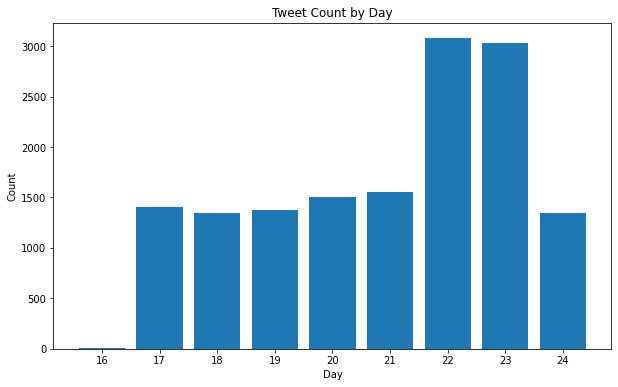

In [31]:
# creating a plot to show tweet volume by day
time_counts_by_day = data['time_day'].value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.bar(time_counts_by_day.index, time_counts_by_day.values)
plt.xticks(np.arange(16,25,1))
plt.title('Tweet Count by Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

- All tweets in the dataset were posted between February 16 and February 24.
- The most active days were February 22nd and 23rd, which were a Sunday and Monday.

In [32]:
# viewing month value counts
data['time_month'].value_counts()

2    14640
Name: time_month, dtype: int64

- All tweets occurred in February.

In [33]:
# viewing year value counts
data['time_year'].value_counts()

2015    14640
Name: time_year, dtype: int64

- All tweets occurred in 2015.

#### Tweet Location

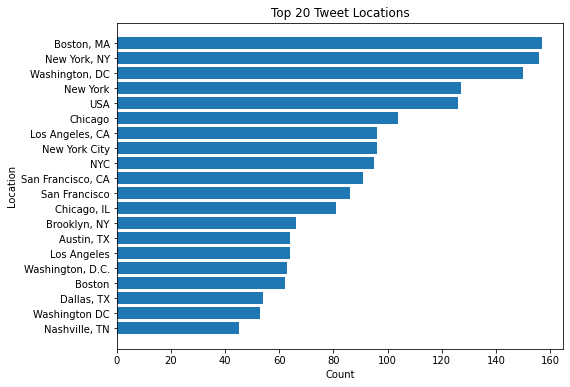

In [34]:
# extracting top 20 most common tweet locations
location_top20 = data['tweet_location'].value_counts()[:20]
# creating plot
plt.figure(figsize=(8,6))
plt.barh(location_top20.sort_values().index, location_top20.sort_values().values)
plt.title('Top 20 Tweet Locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

- At first glance, Boston appears to be the most common tweet location. This makes sense, as Boston Logan International Airport is a busy airport.
- However, 'New York, NY', 'New York', 'New York City', and 'NYC' are all in different categories and surpass Boston when added together (even compared to  'Boston, MA' combined with 'Boston').
- All cities in this list have major airports.

#### User Timezone

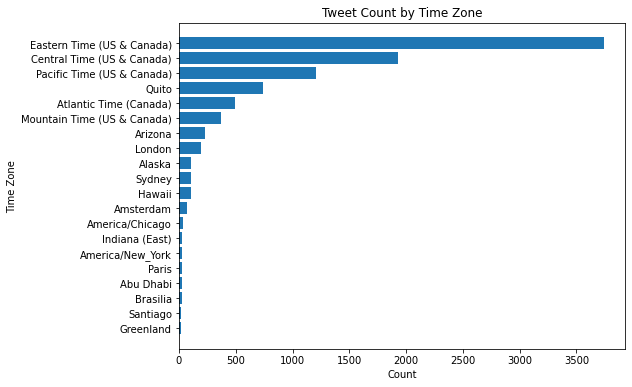

In [35]:
# extracting top 20 most common time zones
timezone_top20 = data['user_timezone'].value_counts()[:20]
# creating plot
plt.figure(figsize=(8,6))
plt.barh(timezone_top20.sort_values().index, timezone_top20.sort_values().values)
plt.title('Tweet Count by Time Zone')
plt.xlabel('Count')
plt.ylabel('Time Zone')
plt.show()

- Similar to the previous column, some values are repeated.
  - 'Eastern Time (US & Canada)' is the same as 'America/New_York'.
- Most users tweeted from the Eastern US time zone, with fewer users tweeting from Central and Pacific.

In [36]:
def stacked_barplot(data, var, target): 
  """
  A function to create a stacked barplot.
  
  data: dataframe
  var: variable
  target: target variable
  """ 
  # creating a table to show values
  values = pd.crosstab(data[var], data[target], margins=True)
  # print(values)
  # print('-'*30)
  # creating the plot
  n_unique = data[var].nunique() # calculating the number of unique values to size the plot
  freq_tab = pd.crosstab(
      data[var], data[target], normalize='index') # creating a normalized table
  freq_tab_sorted = freq_tab.sort_values(
      by=data[target].value_counts().index[0]) # sorting the values
  freq_tab_sorted.plot(
      kind='bar', stacked=True, figsize=(n_unique+2,5), color=['red','royalblue', 'green']) # plotting the values
  plt.xticks(
      rotation=0) # making the labels flat 
  plt.legend(
      loc='upper left', bbox_to_anchor=(1,1)) # moving the legend outside of the plot
  plt.show()

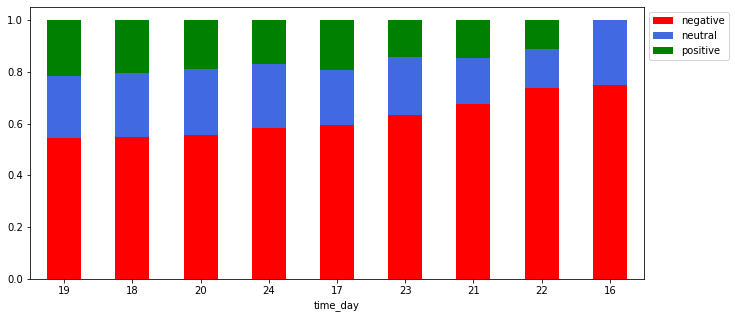

In [37]:
stacked_barplot(data, 'time_day', 'airline_sentiment')

- Tweets on the 21st, 22nd, and 23rd had higher proportions of negative sentiment.
  - These were weekend days -- many people travel over the weekend. The increased travel volume likely contributes to delays and cancellations.

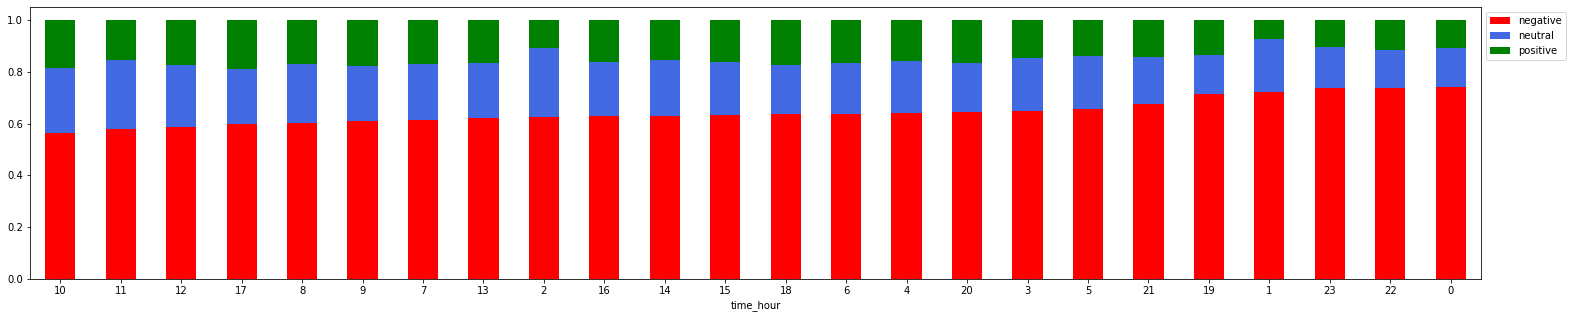

In [38]:
stacked_barplot(data, 'time_hour', 'airline_sentiment')

- While the differences is somewhat small, a higher fraction of tweets late at night (9pm to 1am) are negative.
- People tweeting at those hours could be stuck at the airport due to flight delays and cancellations.

### Data Preprocessing  <a name="preprocessing"></a>

In [39]:
X = data['text']
# defining dependent variable
y = data['airline_sentiment']

In [40]:
# creating several functions to pre-process data and prepare for modeling
# each function receives and returns a list of strings (each tweet is a single string)

# defining a function to remove html
def remove_html(docs):
  cleaned_docs = []
  for doc in docs:
    cleaned_doc = BeautifulSoup(doc, "html.parser")
    cleaned_docs.append(str(cleaned_doc))
  return cleaned_docs

# defining a function to replacing contractions with their composite words
def replace_contractions(docs):
  cleaned_docs = []
  for doc in docs:
    cleaned_doc = contractions.fix(doc)
    cleaned_docs.append(cleaned_doc)
  return cleaned_docs

# defining a function to remove mentions and hashtags
def remove_mentions_and_hashtags(docs):
  cleaned_docs = []
  for doc in docs:
    cleaned_words = []
    for word in doc.split():
      if word.startswith('@') is False and word.startswith('#') is False:
        cleaned_words.append(word)
    cleaned_docs.append(" ".join(cleaned_words))
  return cleaned_docs

# defining a function to remove numbers and hyperlinks
def remove_numbers_and_hyperlinks(docs):
  cleaned_docs = []
  for doc in docs:
    cleaned_doc = re.sub('[^a-zA-Z\s]', "", doc)
    if cleaned_doc != "":# and 'http' not in cleaned_doc:
      cleaned_docs.append(cleaned_doc)
  return cleaned_docs

# defining a function to tokenize the tweets
def tokenize(docs):
  tokenized_docs = []
  for doc in docs:
    tokenized_doc = ToktokTokenizer().tokenize(doc)
    tokenized_docs.append(tokenized_doc)
  return tokenized_docs

# defining a function to remove stopwords
def remove_stopwords(docs):
  stopwords_list = stopwords.words('english')
  cleaned_docs = []
  for doc in docs:
    new_doc = []
    for word in doc:
      if word not in stopwords_list:
        new_doc.append(word)
    cleaned_docs.append(new_doc)
  return cleaned_docs

# defining a function to lemmatize the tweets
def lemmatize(docs):
  lemmatized_docs = []
  lemmatizer = WordNetLemmatizer()
  for doc in docs:
    lemmatized_doc = []
    for word in doc:
      lemmatized_word = lemmatizer.lemmatize(word, pos='v')
      lemmatized_doc.append(lemmatized_word)
    lemmatized_docs.append(lemmatized_doc)
  return lemmatized_docs

# defining a function to combine all previous functions
def text_pre_processer(docs):
  docs = remove_html(docs)
  docs = replace_contractions(docs)
  docs = remove_mentions_and_hashtags(docs)
  docs = remove_numbers_and_hyperlinks(docs)
  docs = tokenize(docs)
  docs = remove_stopwords(docs)
  docs = lemmatize(docs)
  return docs

In [41]:
# converting X to a list
X = X.to_list()
# running the pre-processor function on X
X = text_pre_processer(X)
# converting X to a series
X = pd.Series(X)
# joining all words in each tweet together (separated by spaces)
X = X.apply(lambda x: str(" ".join(x)))

In [42]:
X.shape

(14640,)

- We still have 14,640 tweets.

In [43]:
X.sample(5)

13801                                                                                        gate I get plane
3167     reFlight Booking Problemss last days time unite wait time lt second Kudos excellent customer service
11929                                 worry I send letter I expect compensation I fly twice week wyou guysfor
11253                thank cincyjust landedyou add frequent flyer miles account long incredibly frustrate day
268                                 Adds Pillows Instead LieFlat Seats First Class Arms Race httptcorGYwJBbhm
dtype: object

- The tweets are cleaned and ready for model building.
- We will convert the text to lowercase with the Count and TF-IDF Vectorizers.

### Count Vectorizer and Random Forest Model  <a name="cv"></a>

#### Initializing Count Vectorizer

In [44]:
# initializing instance of CountVectorizer (converts all words to lowercase)
cv = CountVectorizer(lowercase=True, tokenizer=None)

# fitting CV and transforming X
X_cv = cv.fit_transform(X)

# viewing shape of X_cv
X_cv.toarray().shape

(14640, 11060)

- Count Vectorizer gave us 11,060 different features (or words).

#### Building Model with CV Data

In [45]:
# separating X_cv and y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_cv, y, test_size=0.2, random_state=1, stratify=y)

In [46]:
# initializing Random Forest Classifier with 100 estimators
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=1)

# fitting RFC to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

#### Viewing Model Performance

In [47]:
# viewing cross validation scores for the random forest classifier trained on the count vectorized data
cv_cv_scores = cross_val_score(rf, X_train, y_train, cv=10)
cv_cv_scores

array([0.77389078, 0.77047782, 0.75234842, 0.78138343, 0.75405636,
       0.77113578, 0.75149445, 0.77625961, 0.75234842, 0.75661827])

In [48]:
np.mean(cv_cv_scores)

0.7640013348761159

- The Random Forest Classifier has an average CV score of 0.764.
- Next we will determine the optimum number of estimators.

In [50]:
# testing performance of the random forest classifier with different n_estimators values

# creating a list of numbers to define n_estimators
array_estimators = [x for x in np.arange(1, 200, 19)]

# collecting cross validation scores for each random forest classifier
cv_scores = []
for num in array_estimators:
  rfc = RandomForestClassifier(n_estimators = num)
  scores = cross_val_score(rfc, X_train, y_train, cv = 5, scoring = 'accuracy')
  cv_scores.append(np.mean(scores))

In [51]:
# converting accuracy scores to error scores
errors = [1 - x for x in cv_scores]
# finding the n_estimators value that results in the lowest error
least_error = array_estimators[errors.index(min(errors))]

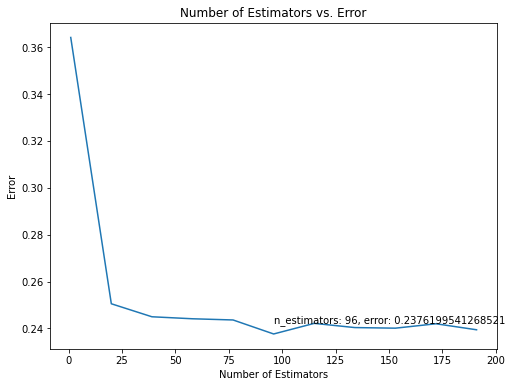

In [52]:
# plotting error for each random forest classifier 
plt.figure(figsize=(8,6))
plt.plot(array_estimators, errors)
xy = (least_error, (min(errors)+0.005))
plt.annotate(f'n_estimators: {least_error}, error: {min(errors)}', xy=xy, textcoords='data')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Number of Estimators vs. Error')
plt.show()

- The best n_estimators value is 96, with an error of 0.238.
- These is a large dropoff in error at around 20 estimators.

In [53]:
# initializing random forest classifier with best n_estimators value
rf_best_estimators = RandomForestClassifier(n_estimators = 96)
# fitting model to training data
rf_best_estimators.fit(X_train, y_train)

RandomForestClassifier(n_estimators=96)

In [54]:
# using model to make predictions on X_test
y_pred = rf_best_estimators.predict(X_test)

In [55]:
# viewing performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.82      0.91      0.86      1835
     neutral       0.60      0.51      0.56       620
    positive       0.74      0.58      0.65       473

    accuracy                           0.77      2928
   macro avg       0.72      0.67      0.69      2928
weighted avg       0.76      0.77      0.76      2928



- Our model correctly predicted 77% of the test data.
- 91% of negative tweets were correctly identified.
  - Recall scores for neutral and positive tweets were much lower -- 51% and 58% respectively.
- These discrepancies may result from the imbalanced dataset. We have far more negative tweets, which is likely training the model to better classify negative tweets than neutral or positive ones.

#### Viewing Confusion Matrix

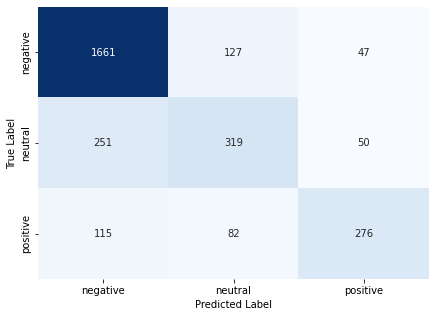

In [56]:
# creating labels for axes 
labels = ['negative', 'neutral', 'positive']

# defining a function to create a confusion matrix
def make_confusion_matrix(y_test, y_pred, labels):
  """
  Function to create a confusion matrix.

  y_test: True values for y.
  y_pred: Values for y predicted by model.
  labels: labels for plot axes.
  """
  cf_matrix = confusion_matrix(y_test, y_pred, labels = labels)
  plt.figure(figsize=(7,5))
  sns.heatmap(cf_matrix, fmt='', cmap='Blues', cbar=False, annot=True)
  plt.xticks([.5,1.5,2.5], labels=labels)
  plt.yticks([.5,1.5,2.5], labels=labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

# plotting confusion matrix
make_confusion_matrix(y_test, y_pred, labels)

- As we saw in the classification report, most negative tweets were correctly identified.
  - Of the negative tweets, 1661 were classified as negative, 127 were classified as neutral, and 47 were classified as positive.
- The model seemed to struggle with neutral tweets. 251 of them were classified as negative -- almost as many as were correctly classified as neutral.
- Positive tweet classifications were slightly more accurate than neutral.

#### Viewing Most Important Words

In [57]:
# extracting top 40 feature names and importances
cv_feature_importances = dict(zip(cv.get_feature_names_out(), rf_best_estimators.feature_importances_))
cv_feature_importances = {k: v for k, v in sorted(cv_feature_importances.items(), key=lambda item: item[1], reverse=True)}
cv_top_40_words = list(cv_feature_importances)[:40]

# creating top 40 dataframe
cv_top_40_df = pd.DataFrame(cv_top_40_words, index=list(np.arange(1,41,1)), columns=['word'])
cv_top_40_df

,word
1,thank
2,thanks
3,great
4,delay
5,flight
6,hold
7,hours
8,love
9,awesome
10,call


- The top few words underscore our observations from the wordclouds during EDA.
  - 'Thank', 'thanks', and 'great' are all solid indications that a tweet is positive.
  - The next few words most likely describe situations where a flight is delayed: 'delay', 'flight', 'hold', and 'hours'. Twitter users that use these words in a tweet are probably posting about a negative experience.
- The subsequent words are a mixture of positive and negative:
  - 'Awesome', 'love', 'best', 'appreciate', and 'amaze' clearly suggest a positive experience,
  - Words like 'cancelled', 'bag', 'wait', 'never', and 'worst' are probably used to describe flight delays and baggage issues, both reasons for negative experiences.

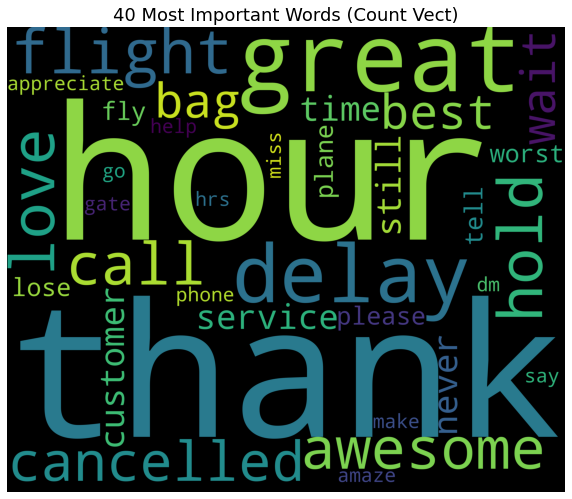

In [58]:
# combining top 40 words into a single string
cv_top_40_words_joined = ' '.join(cv_top_40_words)
# creating wordcloud
create_wordcloud(cv_top_40_words_joined, '40 Most Important Words (Count Vect)')

- This is a visual representation of the preceding list. 'Thank', 'great', 'hour', 'delay', 'love', 'awesome', and 'cancelled' are the most important words to identify tweet sentiment.

### TF-IDF and Random Forest Model  <a name="tf"></a>

#### Initializing TF-IDF Vectorizer

In [59]:
# initializing instance of tf-idf vectorizer (converts text to lowercase)
tf_idf = TfidfVectorizer(lowercase=True, preprocessor=None)
# fitting the vectorizer and transforming data
X_tf_idf = tf_idf.fit_transform(X)

#### Building Model with TF-IDF Data

In [60]:
# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.2, stratify = y)

In [61]:
# initializing RFC
rf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
# fitting the classifier to the training data
rf2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

#### Testing Model Performance

In [62]:
# calculating cross validation scores
idf_cv_scores = cross_val_score(rf2, X_train, y_train, scoring='accuracy', cv=10)
idf_cv_scores

array([0.75170648, 0.77474403, 0.74722459, 0.75918019, 0.76345004,
       0.77455167, 0.77711358, 0.7557643 , 0.74978651, 0.76686593])

In [63]:
np.mean(idf_cv_scores)

0.7620387318093983

- The Random Forest Classifier trained on the TF-IDF data had an average accuracy of 0.762.

In [64]:
# computing cross validation scores for different n_estimator values
idf_cv_scores = []
for num in array_estimators:
  rf = RandomForestClassifier(n_estimators = num)
  scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=5)
  idf_cv_scores.append(np.mean(scores))

In [65]:
# converting accuracy scores to error scores
idf_errors = [1 - score for score in idf_cv_scores]
idf_least_error = array_estimators[idf_errors.index(min(idf_errors))]

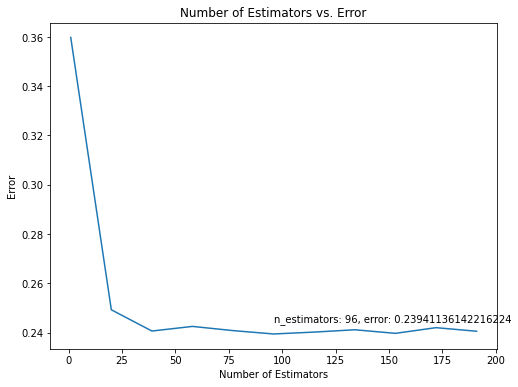

In [66]:
# plotting error scores for each classifier
plt.figure(figsize=(8,6))
plt.plot(array_estimators, idf_errors)
xy = (idf_least_error, (min(idf_errors)+.005))
plt.annotate(f'n_estimators: {idf_least_error}, error: {min(idf_errors)}', xy=xy, textcoords='data')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Number of Estimators vs. Error')
plt.show()

- The best model had 96 estimators and an error score of 0.239.

In [68]:
# initializing random forest classifier with optimal number of estimators
rf2_best_estimators = RandomForestClassifier(n_estimators = 96)
# fitting model to training data
rf2_best_estimators.fit(X_train, y_train)

RandomForestClassifier(n_estimators=96)

In [69]:
# using model to predict on X_test
y_pred2 = rf2_best_estimators.predict(X_test)

In [70]:
# viewing classification report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

    negative       0.79      0.94      0.86      1835
     neutral       0.67      0.45      0.54       620
    positive       0.78      0.55      0.65       473

    accuracy                           0.77      2928
   macro avg       0.75      0.64      0.68      2928
weighted avg       0.76      0.77      0.75      2928



- While the accuracy score is the same as our last model, the recall for negative tweets went up 3%.
  - Precision is 4% lower, however.
- Recall for neutral and positive tweets also decreased.

#### Viewing Confusion Matrix

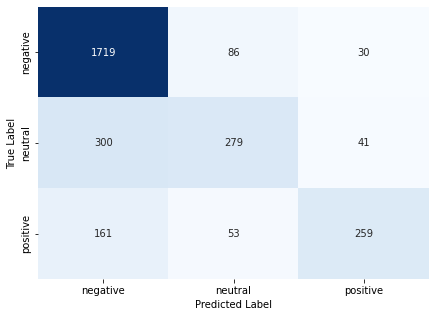

In [71]:
make_confusion_matrix(y_test, y_pred2, labels=labels)

- Here we see why recall increased but precision decreased for negative tweets.
  - While the model correctly classified 1719 tweets as negative, it also misclassified 300 neutral tweets as negative. That's more tweets than the model correctly identified as neutral (251).
- Performance on positive tweets is more or less than same as the previous model.

#### Viewing Most Important Words

In [72]:
# extracting top feature names and importances
idf_feature_importances = dict(zip(tf_idf.get_feature_names_out(), rf2_best_estimators.feature_importances_))
idf_feature_importances = {k: v for k, v in sorted(idf_feature_importances.items(), key=lambda item: item[1], reverse=True)}
idf_top_40_words = list(idf_feature_importances)[:40]
# creating top 40 dataframe
idf_top_40_df = pd.DataFrame(idf_top_40_words, index=list(np.arange(1,41,1)), columns=['word'])
idf_top_40_df

,word
1,thank
2,thanks
3,great
4,flight
5,delay
6,love
7,hours
8,get
9,cancelled
10,hold


- Many words in this list are repeated from the Count Vectorizer model. Let's put the two together for easy comparison.

In [73]:
# comparing most importance words from TF-IDF and Count Vectorizer
word_comparison_df = pd.concat([idf_top_40_df[:20], cv_top_40_df[:20]], axis=1)
word_comparison_df.columns = ['idf','cv']
word_comparison_df

,idf,cv
1,thank,thank
2,thanks,thanks
3,great,great
4,flight,delay
5,delay,flight
6,love,hold
7,hours,hours
8,get,love
9,cancelled,awesome
10,hold,call


- The first 5 words from both lists are the same words in slightly different order.
  - 'Thank', 'thanks', 'great', 'flight' and 'delay' were found by both models to be significant indications of sentiment. We can be fairly certain that these words are strong indicators of a customer's quality of experience.
- While the order varies, both lists are fairly similar to one another.
  - 'Awesome', 'love', 'hold', and 'cancelled' all made the top 11 for both models.


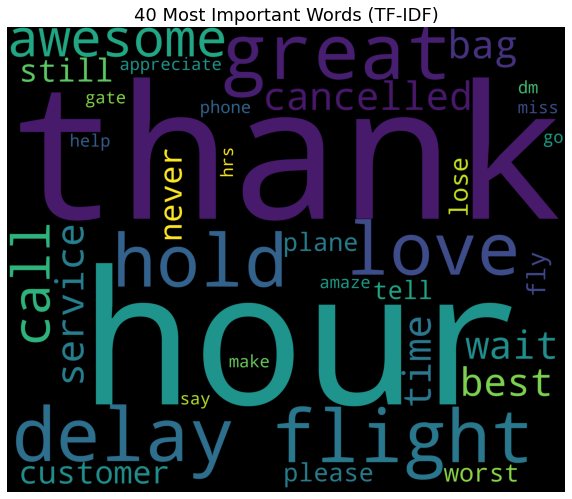

In [74]:
# creating string of top 40 words
idf_top_40_words_joined = ' '.join(cv_top_40_words)
# plotting wordcloud
create_wordcloud(idf_top_40_words_joined, '40 Most Important Words (TF-IDF)')

- 'Thank', 'hour', 'great', 'flight', 'delay', and 'cancelled' are all prominent in the wordcloud. These words were also in the previous wordcloud, underscoring their importance.

## Actionable Insights and Recommendations  <a name="recs"></a>


## Insights
- The majority of tweets about airlines are negative: customers usually take to Twitter to post about negative experiences and not positive ones.
- Customers tend to be upset about customer service issues, flight delays, and last minute cancellations.
  - A smaller proportion of tweets document luggage problems, bad flights, and issues with booking or flight attendants.
- Delta and Southwest appear to garner the fewest negative tweets, whereas United, US Airways, and American Airlines have much higher rates of negative tweets.
- A higher fraction of tweets are negative during the weekends. This is likely the result of busier travel days leading to more delays and cancellations.
- A large number of tweets originate from large airports on the east coast. 

## Recommendations  
- Use one or both classification models to identify tweet sentiment.

### Negative Tweets
- For negative tweets, determine causes and map out areas for improvement.

- Addressing Customer Service Issues:
  - Airlines should further investigate customer service issues and determine the  causes. 
  - If complaints about an airline's customer service are valid, then the airline may need to better train their employees or improve their hiring process to select candidates with stronger customer service skills. 
  - An airline may also redesign their communication protocol to better communicate with customers by managing expectations. For instance, if travel volume is high and delays are expected, the airline can indicate this to the customer during the booking process. Customers who are informed of possible delays well ahead of time are better able to devise contingency plans. It is understandable that a customer who is surprised by a last minute delay or cancellation will be upset. Communicating this possibility may preclude an emotional reaction in the customer.

- Addressing Flight Delays and Cancellations:
  - Another aspect of managing customer sentiment is by preventing delays and cancellations in the first place.
  - If delays and cancellations occur often, the airline should look into improving their fleet allocation. If that means having fewer flights or investing in more planes, the long term benefits of customer satisfaction and loyalty may outweigh the short term decreases in profit.
  - If delays and cancellations do occur, are there more steps the airline can take to recover the customer's experience? Examples: hotel vouchers, flight vouchers, free upgrades, etc.
  - An airline can create a dedicated recovery team to assist customers during delays and cancellations. Many negative tweets result from situations where customers experience delays without receiving any help from the airline. A dedicated team of employees can step in and provide solutions, which will improve the quality of interaction and allow other airline employees to focus on other responsibilities.

- Addressing Luggage Issues:
  - If luggage is lost, the airline should study the end-to-end luggage transportation process and identify weaknesses. Beyond the typical barcode-scanning standard, cameras can be installed along luggage transportation routes to catalogue and identify bags as they travel between destinations. 
  - If luggage is damaged, there can be an investigation into when the damage occurred. If it was employee error, then that employee can be better instructed on how to properly handle baggage. Cameras can aid in this process too by capturing the state of luggage at each point in its journey.


### Positive Tweets
- Identify trends among positive tweets. The airline can emphasize aspects of service that leave a good impression on the customer.
    - Example: There are several tweets commending the customer service of a particular airline. The airline may then go further to convey the importance of customer service when hiring and training employees in order to maximize customer satisfaction.

---
## Areas for Improvement
- Use other sentiment analysis techniques like VADER
- Incorporate survey data to better gauge customer satisfaction
- Analyze lost baggage data by airline
- Analyze flight delay data by airline
- Use hyperparameter tuning when building models